---
title: Basic Example
toc: true
---

In this notebook, we will see how to use Polire for spatial interpolation.

In [3]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

import polire
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score,
)

# set default cmap
plt.rcParams["image.cmap"] = "RdYlGn_r"
xr.set_options(cmap_sequential="RdYlGn_r")

## Load the data

In [4]:
ds = xr.tutorial.open_dataset("air_temperature")
ds

<xarray.Dataset>
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 ...
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

Let's visualize the spatial data from a time-stamp.

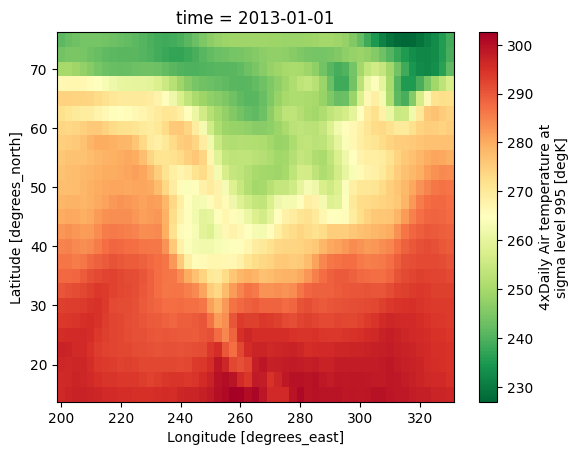

In [5]:
ds_spatial = ds.isel(time=0)
ds_spatial["air"].plot()
plt.show()

Let's assume that only 10% of the data is available and try to interpolate the rest of the data.

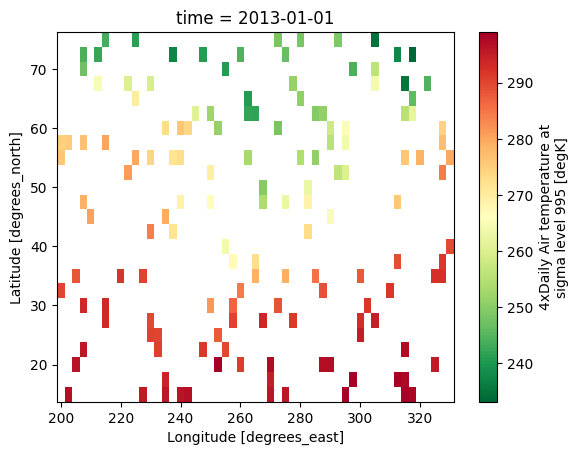

In [6]:
ds_spatial_train = ds_spatial.copy()

np.random.seed(42)
ds_spatial_train["air"].values = np.where(
    np.random.rand(*ds_spatial_train["air"].shape) > 0.1,
    np.nan,
    ds_spatial_train["air"].values,
)


ds_spatial_train["air"].plot()
plt.show()

## Prepare the data

In [7]:
train_df = ds_spatial_train["air"].to_dataframe().reset_index()
train_df = train_df.dropna()

X_train = train_df[["lat", "lon"]].values
y_train = train_df["air"].values

test_df = ds_spatial["air"].to_dataframe().reset_index()
X_test = test_df[["lat", "lon"]].values
y_test = test_df["air"].values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(146, 2) (146,) (1325, 2) (1325,)


## Useful plotting function

In [8]:
def plot_predictions(y_pred, model_name):
    fig, axes = plt.subplots(
        1, 3, figsize=(15, 4), gridspec_kw={"width_ratios": [1, 1, 0.05]}
    )

    ax = axes[0]
    ds_spatial["air"].plot(ax=ax, add_colorbar=False)
    ax.set_title("True values")

    ax = axes[1]
    ds_spatial_pred = ds_spatial_train.copy()
    ds_spatial_pred["air"].values = y_pred
    mappable = ds_spatial_pred["air"].plot(ax=ax, add_colorbar=False)
    ax.set_title(f"{model_name}")

    ax = axes[2]
    fig.colorbar(mappable, cax=ax)

## Models

### IDW

/home/patel_zeel/polire/polire/idw/idw.py:82: RuntimeWarning: divide by zero encountered in divide
  weights = 1 / np.power(dist, self.exponent)
/home/patel_zeel/polire/polire/idw/idw.py:83: RuntimeWarning: invalid value encountered in divide
  result = (weights * self.y[:, None]).sum(axis=0) / weights.sum(axis=0)


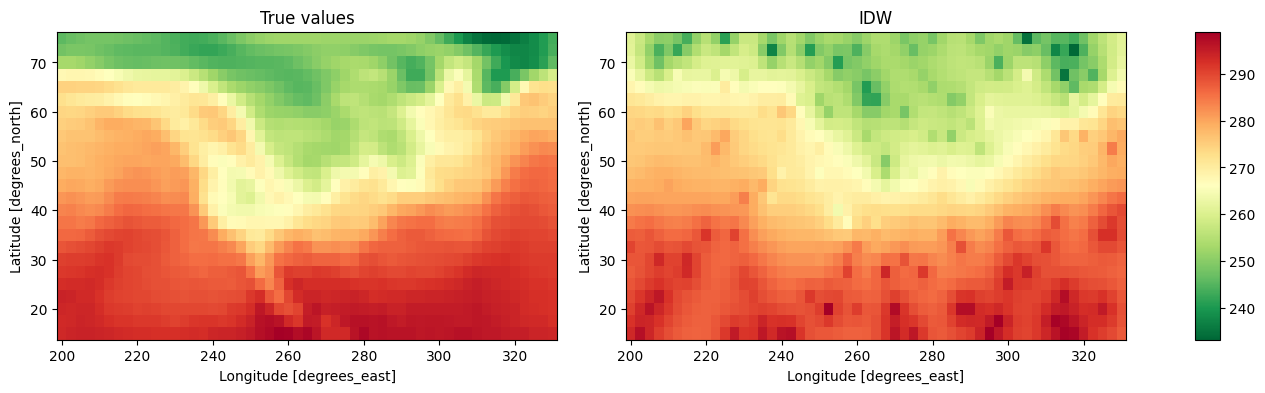

In [9]:
idw = polire.IDW(exponent=2)
idw.fit(X_train, y_train)
idw_pred = idw.predict(X_test).reshape(ds_spatial["air"].shape)

plot_predictions(idw_pred, "IDW")

### Kriging

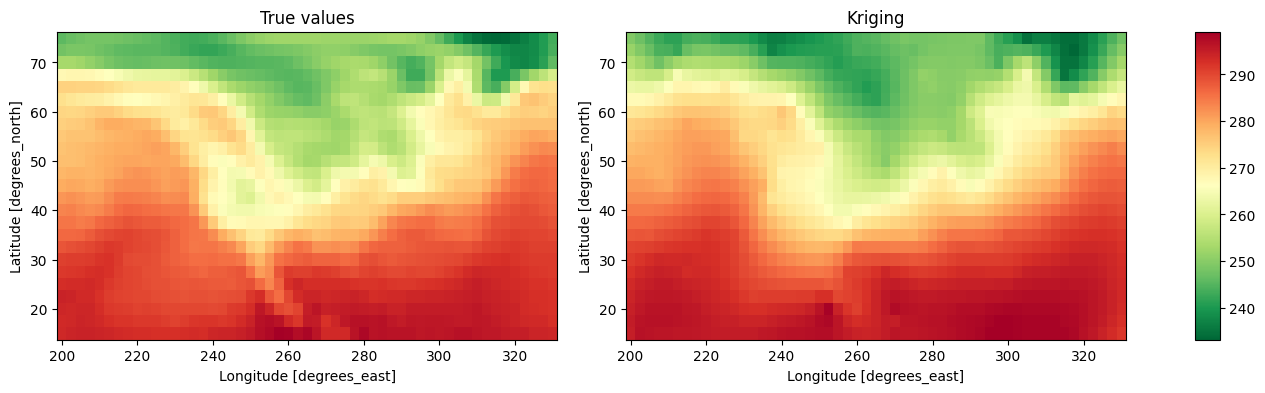

In [10]:
kriging = polire.Kriging(variogram_model="spherical")
kriging.fit(X_train, y_train)
kriging_pred = kriging.predict(X_test).reshape(ds_spatial["air"].shape)

plot_predictions(kriging_pred, "Kriging")

### Spline

/home/patel_zeel/miniconda3/envs/polire/lib/python3.10/site-packages/scipy/interpolate/_fitpack_impl.py:593: RuntimeWarning: The required storage space exceeds the available storage space.
Probable causes: nxest or nyest too small or s is too small. (fp>s)
	kx,ky=3,3 nx,ny=11,11 m=146 fp=1143.783495 s=128.911993
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


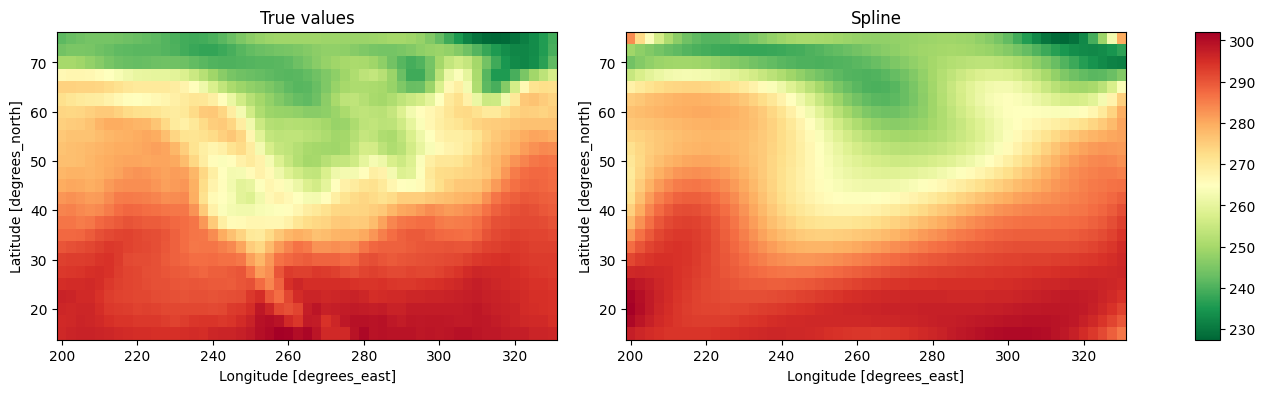

In [11]:
spline = polire.Spline()
spline.fit(X_train, y_train)
spline_pred = spline.predict(X_test).reshape(ds_spatial["air"].shape)

plot_predictions(spline_pred, "Spline")

### Trend

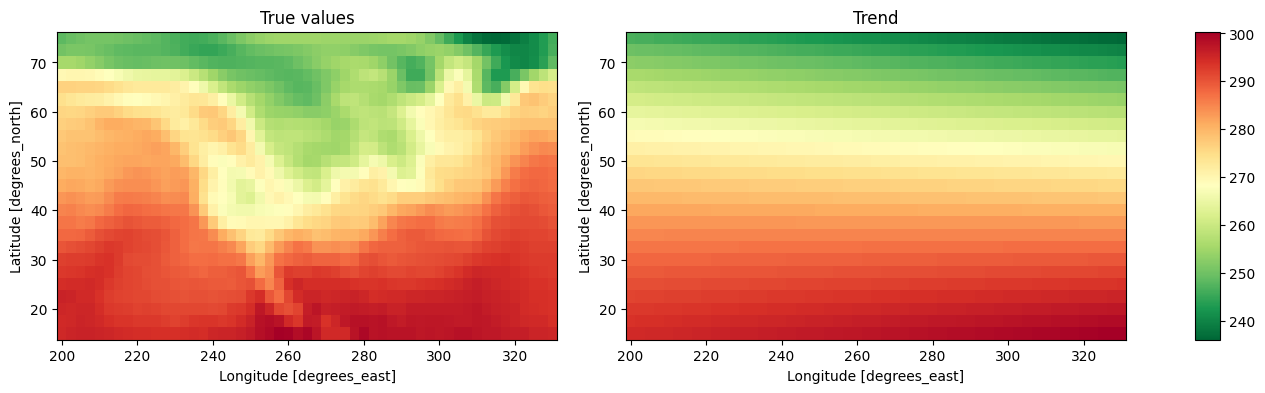

In [12]:
trend = polire.Trend(order=2)
trend.fit(X_train, y_train)
trend_pred = trend.predict(X_test).reshape(ds_spatial["air"].shape)

plot_predictions(trend_pred, "Trend")

### SpatialAverage

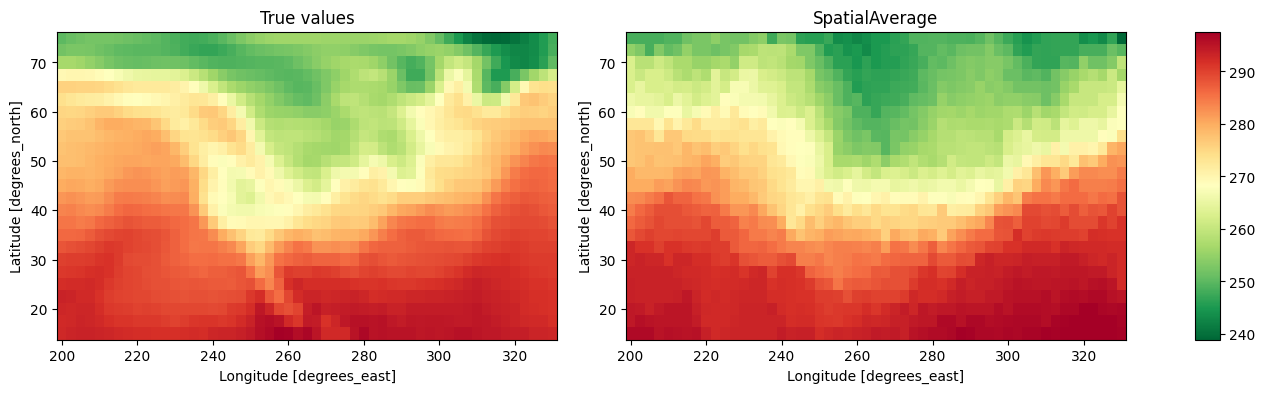

In [13]:
spatial_average = polire.SpatialAverage(radius=15)
spatial_average.fit(X_train, y_train)
spatial_average_pred = spatial_average.predict(X_test).reshape(ds_spatial["air"].shape)

plot_predictions(spatial_average_pred, "SpatialAverage")

### LinearRegression

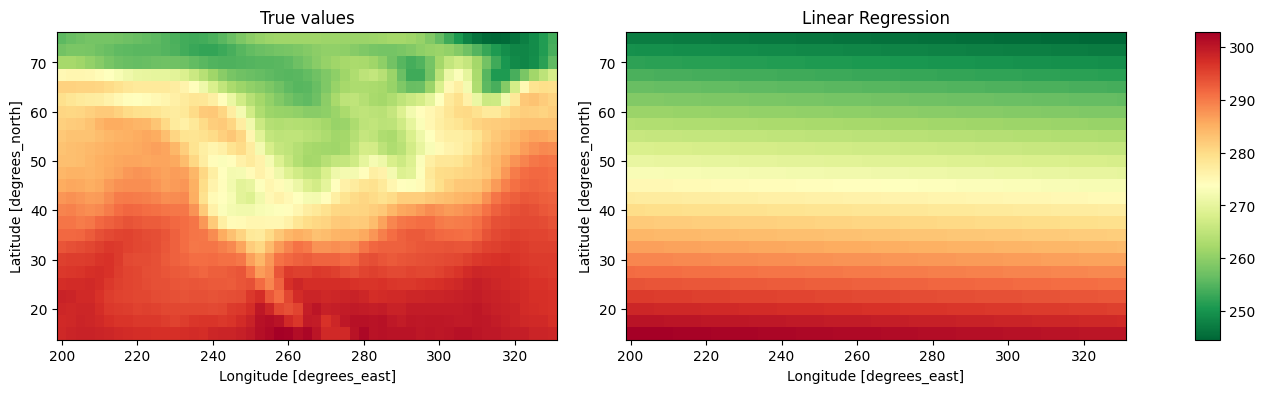

In [14]:
lr = polire.CustomInterpolator(LinearRegression())
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test).reshape(ds_spatial["air"].shape)

plot_predictions(lr_pred, "Linear Regression")

### NearestNeighbors

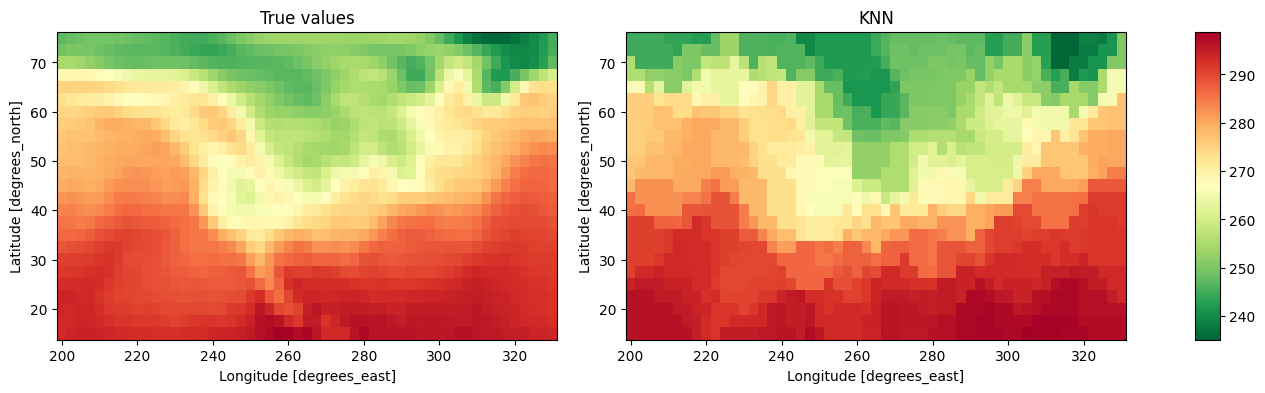

In [15]:
K = 3
knn = polire.CustomInterpolator(KNeighborsRegressor(n_neighbors=K))
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test).reshape(ds_spatial["air"].shape)

plot_predictions(knn_pred, "KNN")

### Random Forest

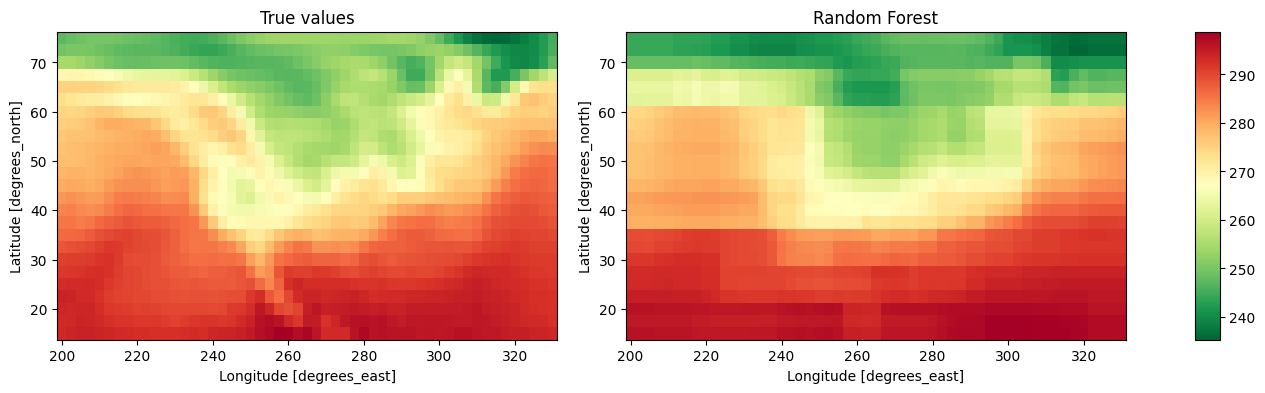

In [16]:
rf = polire.CustomInterpolator(RandomForestRegressor(random_state=42))
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test).reshape(ds_spatial["air"].shape)

plot_predictions(rf_pred, "Random Forest")

## Checking performance

In [17]:
models = {
    "Inverse Distance Weighting": idw_pred,
    "Kriging (spherical)": kriging_pred,
    "Spline": spline_pred,
    "Trend": trend_pred,
    "Linear Regression": lr_pred,
    f"{K}-Nearest Neighbors": knn_pred,
    "Random Forest": rf_pred,
    "Spatial Average": spatial_average_pred,
}

result = pd.DataFrame(columns=["RMSE", "MAE", "MAPE", "Neg R2"], index=models.keys())

for model_name, y_pred in models.items():
    result.loc[model_name, "RMSE"] = mean_squared_error(
        y_test.ravel(), y_pred.ravel(), squared=False
    )
    result.loc[model_name, "MAE"] = mean_absolute_error(y_test.ravel(), y_pred.ravel())
    result.loc[model_name, "MAPE"] = mean_absolute_percentage_error(
        y_test.ravel(), y_pred.ravel()
    )
    result.loc[model_name, "Neg R2"] = -r2_score(y_test.ravel(), y_pred.ravel())

result.sort_values("RMSE").style.highlight_min(axis=0, color="green").format("{:.2f}")

,RMSE,MAE,MAPE,Neg R2
Kriging (spherical),3.10,1.95,0.01,-0.97
Random Forest,3.96,2.74,0.01,-0.96
Spline,4.43,2.85,0.01,-0.95
3-Nearest Neighbors,4.60,3.19,0.01,-0.94
Spatial Average,6.04,4.32,0.02,-0.90
Inverse Distance Weighting,6.54,5.04,0.02,-0.88
Trend,8.02,6.30,0.02,-0.82
Linear Regression,8.46,6.98,0.03,-0.80
